# Text Classification (MultiClass)

In this task, we are given with some text, and a label corresponding to it. 

Since we do not really have the domain knowledge regarding the given dataset, we can only/mostly work with the text vectorization techniques, and domain based feature engineering would be out of question for this dataset.

## Importing important libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

## Reading the dataset

We will first try to read the dataset, and look at the few entries to get familiar with the dataset in hand.

In [2]:
df = pd.read_csv('train_set.csv', encoding = "ISO-8859-1")
test_df = pd.read_csv('test_set.csv')

display(df.head())
print(f"Shape of training set = {df.shape}")
print(f"Shape of testing set = {test_df.shape}")

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for circuit breaker captive consumption
2,85389000,lv ma pd trip unit for cvs parts of circuit breakers
3,85389000,lv na p trip unit for cvs switch parts of circuit breaker
4,85389000,lv tmd pd trip unit for cvs parts of circuitbreakers


Shape of training set = (23615, 2)
Shape of testing set = (5894, 1)


In [3]:
print(f"Total number of unique classes = {df.label.nunique()}")

Total number of unique classes = 12


Let's look at the distribution of the classes.

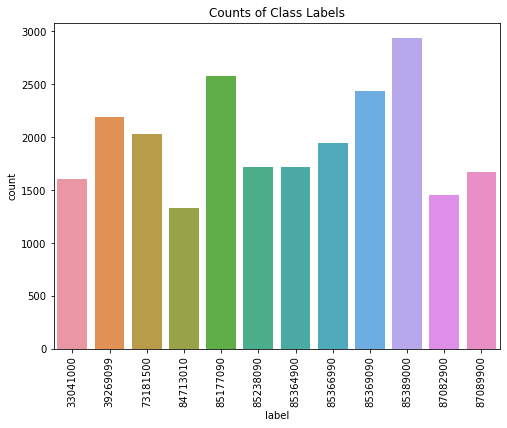

In [4]:
#checking the occurrences of various classes
plt.figure(figsize = (8, 6))
sns.countplot(df.label)
plt.xticks(rotation = 90)
plt.title('Counts of Class Labels')
plt.show()

Looking at the class distribution, we can see that the dataset is not quite biased towards a single class, and has good number of instances for each and every class. This also implies that we can use accuracy as an evaluation metric.

We will look at some more stats from the text data.

Average length of sentence = 8.555197967393605 words
Smallest sentence length = 1
Largest sentence length = 21


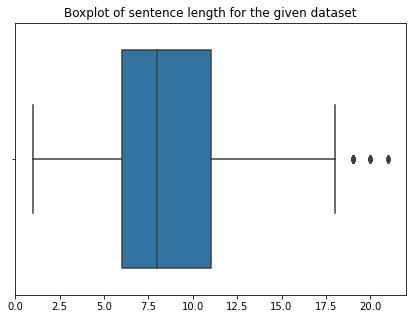

In [5]:
#let's look at the average number of words that the texts contain
sentence_lens = df.text.apply(lambda x: len(x.split())).values
print(f"Average length of sentence = {np.mean(sentence_lens)} words")
print(f"Smallest sentence length = {min(sentence_lens)}")
print(f"Largest sentence length = {max(sentence_lens)}")

#checking the distribution of the sentence lengths
plt.figure(figsize = (7, 5))
plt.title("Boxplot of sentence length for the given dataset")
sns.boxplot(sentence_lens)
plt.show()

We see that most of the texts have their lengths between 6 and 11 words, while some have as many as 20+ words, and some even have as less as 1 word.

## Data Cleaning

We will first try to clean the dataset a bit, which would include:

1) Removing stopwords <br>
2) Removing words having a length of less than 2 <br>
3) Stripping extra white spaces

In [6]:
#preprocessing the sentences a bit

#removing the stopwords
stop_words = stopwords.words('english')
stop_words.remove('not')
#removing words having length less than 2
df['text'] = df['text'].apply(lambda x: ' '.join(
                    [ele for ele in x.split() if len(ele) >= 2 and ele not in stop_words]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(
                            [ele for ele in x.split() if len(ele) >= 2 and ele not in stop_words]))

## Splitting into Train and Test

In [7]:
#now we will vectorize the texts
y_train = df.pop('label')
x_train = df.text
#splitting the dataset into train, cv and test
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train.values, test_size = 0.2,
                                                    random_state = 32)

print(f"Shape of x_train = {x_train.shape}\nShape of x_test = {x_test.shape}")

Shape of x_train = (18892,)
Shape of x_test = (4723,)


## Data Featurization

Now we will vectorize the dataset, using Bag of Words approach.<br>
We will be using an n-gram range of 1 to 3, and also the minimum document frequency of 10, so as to remove unwanted rare words.

In [8]:
count = CountVectorizer(min_df = 10, ngram_range = (1,3))
x_train_vect = count.fit_transform(x_train)
x_test_vect = count.transform(x_test)

print(f"Shape of vectorized x_train = {x_train_vect.shape}")
print(f"Shape of vectorized x_test = {x_test_vect.shape}")

#also featurizing the original test data, without labels
x_test_final = count.transform(test_df.text.values)
print(f"Shape of vectorized unseen test data = {x_test_final.shape}")

Shape of vectorized x_train = (18892, 4051)
Shape of vectorized x_test = (4723, 4051)
Shape of vectorized unseen test data = (5894, 4051)


## Model Training


Now we will start the modelling for the given dataset. Since we have textual data, with very high dimensionality, we will avoid tree based models, because of their performance degradation and the increase in time-complexities for high dimensional data.

We will do a normal grid search for each of these models, and check the performance on our test set, and choose the model which gives best performance on our test set. We will use a 4-fold cross validation for each of these models.

In [28]:
#defining a helper function

def plot_accuracy_versus_hyperparam(params, train_results, cv_results, hyperparameter_name,
                                    log_scale = False):
    plt.figure(figsize=(9,6))
    plt.title(f'Hyperparameter-{hyperparameter_name} vs Accuracy Score')
    plt.plot(params, cv_results, label = 'CV Score')
    plt.plot(params, train_results, label = 'Train Score')
    if log_scale:
        plt.xscale('log')
    plt.xlabel(hyperparameter_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### Logistic Regression

In [29]:
#now we will be fitting the models

#defining the range of values for the hyperparameter alpha
param = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

cv_accuracy = []
train_accuracy = []
for ele in param['alpha']:

    clf = SGDClassifier(loss = 'log',
                        penalty = 'l2',
                        alpha = ele,
                        class_weight = 'balanced', n_jobs = -1)

    scores = cross_val_score(clf,
                             x_train_vect,
                             y_train,
                             scoring = 'accuracy',
                             cv = 4,
                             n_jobs = -1)

    print("The mean CV accuracy with alpha = {} is = {}".format(ele, round(np.mean(scores), 4)))
    #appending the train and cv scores to the list
    cv_accuracy.append(np.mean(scores))
    
    #fitting the model on whole training dataset, to get the train accuracy too
    clf.fit(x_train_vect, y_train)
    train_accuracy.append(accuracy_score(y_train, clf.predict(x_train_vect)))

The mean CV accuracy with alpha = 0.0001 is = 0.9029
The mean CV accuracy with alpha = 0.001 is = 0.8684
The mean CV accuracy with alpha = 0.01 is = 0.8074
The mean CV accuracy with alpha = 0.1 is = 0.7459
The mean CV accuracy with alpha = 1 is = 0.6407
The mean CV accuracy with alpha = 10 is = 0.4971
The mean CV accuracy with alpha = 100 is = 0.2637


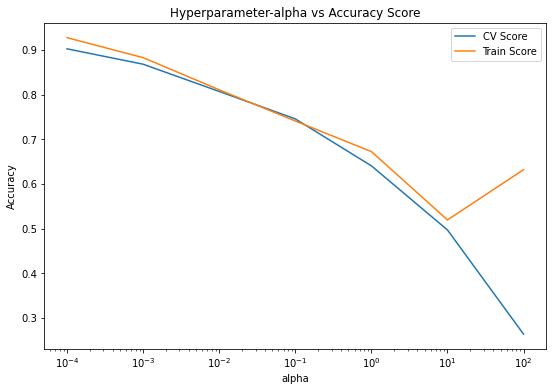

In [30]:
plot_accuracy_versus_hyperparam(param['alpha'], train_accuracy, cv_accuracy, 'alpha', True)

From looking at the plot of hyperparameter-alpha vs the accuracy metric, we can see that alpha = 0.0001 gives the best CV Score. So we will train our final model using that hyperparameter, and check the performance on test dataset.

In [31]:
clf = SGDClassifier(loss = 'log',
                    penalty = 'l2',
                    alpha = 0.0001,
                    class_weight = 'balanced')

clf.fit(x_train_vect, y_train)

test_acc = accuracy_score(y_test, clf.predict(x_test_vect))
print("The final accuracy on Test Dataset is: {}".format(round(test_acc, 4)))

The final accuracy on Test Dataset is: 0.9102


### Linear SVM

In [32]:
#defining the range of values for the hyperparameter alpha
param={'alpha': [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100, 1000]}

cv_accuracy = []
train_accuracy = []
for ele in param['alpha']:
    
    clf = SGDClassifier(loss = 'hinge',
                        penalty = 'l1',
                        alpha = ele,
                        class_weight = 'balanced', n_jobs = -1)
        
    scores=cross_val_score(clf,
                           x_train_vect,
                           y_train,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
    
    #appending the train and cv scores to the list
    print("The mean CV accuracy with alpha = {} is = {}".format(ele, round(np.mean(scores), 4)))
    cv_accuracy.append(np.mean(scores))
    
    #fitting the model on whole training dataset, to get the train accuracy too
    clf.fit(x_train_vect, y_train)
    train_accuracy.append(accuracy_score(y_train, clf.predict(x_train_vect)))

The mean CV accuracy with alpha = 1e-05 is = 0.9036
The mean CV accuracy with alpha = 0.0001 is = 0.892
The mean CV accuracy with alpha = 0.001 is = 0.7673
The mean CV accuracy with alpha = 0.01 is = 0.5284
The mean CV accuracy with alpha = 0.1 is = 0.1294
The mean CV accuracy with alpha = 1 is = 0.0901
The mean CV accuracy with alpha = 10 is = 0.0795
The mean CV accuracy with alpha = 100 is = 0.0709
The mean CV accuracy with alpha = 1000 is = 0.0951


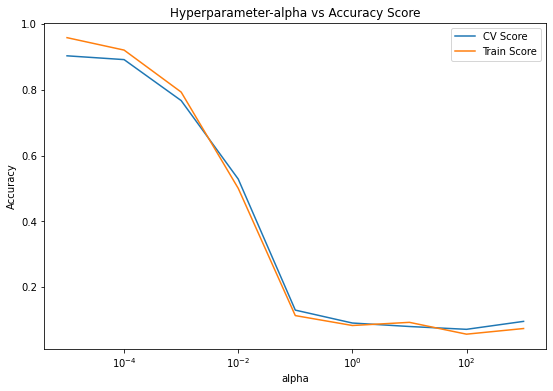

In [33]:
plot_accuracy_versus_hyperparam(param['alpha'], train_accuracy, cv_accuracy, 'alpha', True)

Again, we notice that alpha = 0.00001 gives the best CV Score. So we will train our final model using that hyperparameter, and check the performance on test dataset.

In [34]:
clf = SGDClassifier(loss = 'hinge',
                    penalty = 'l2',
                    alpha = 1e-5,
                    class_weight = 'balanced')

clf.fit(x_train_vect,y_train)

test_acc = accuracy_score(y_test, clf.predict(x_test_vect))
print("The final accuracy on Test Dataset is: {}".format(round(test_acc, 4)))

The final accuracy on Test Dataset is: 0.9153


### Multinomial Naive Bayes

In [35]:
#defining the range of values for the hyperparameter alpha
param = {'alpha':[1e-3, 1e-2, 0.1, 1, 100, 1000]}

cv_accuracy = []
train_accuracy = []
for ele in param['alpha']:
    
    clf = MultinomialNB(alpha = ele)
        
    scores = cross_val_score(clf,
                             x_train_vect,
                             y_train,
                             scoring = 'accuracy',
                             cv = 4,
                             n_jobs = -1)
    
    print("The mean CV accuracy with alpha = {} is = {}".format(ele, round(np.mean(scores), 4)))
    cv_accuracy.append(np.mean(scores))

    #fitting the model on whole training dataset, to get the train accuracy too
    clf.fit(x_train_vect,y_train)
    train_accuracy.append(accuracy_score(y_train,clf.predict(x_train_vect)))

The mean CV accuracy with alpha = 0.001 is = 0.8681
The mean CV accuracy with alpha = 0.01 is = 0.8661
The mean CV accuracy with alpha = 0.1 is = 0.8624
The mean CV accuracy with alpha = 1 is = 0.8532
The mean CV accuracy with alpha = 100 is = 0.7632
The mean CV accuracy with alpha = 1000 is = 0.6441


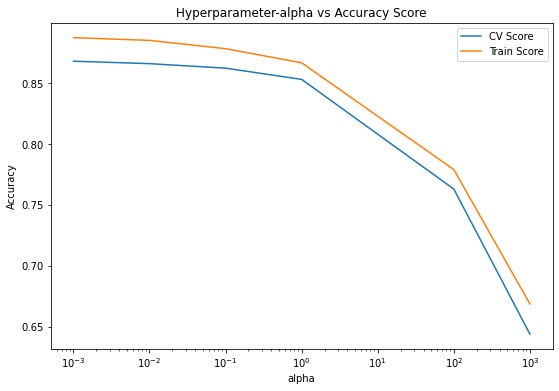

In [36]:
plot_accuracy_versus_hyperparam(param['alpha'], train_accuracy, cv_accuracy, 'alpha', True)

From the above plot, we see that alpha = 0.001 is the best suited hyperparameter for the given model.

In [37]:
clf = MultinomialNB(alpha = 1e-3)
clf.fit(x_train_vect, y_train)

test_acc = accuracy_score(y_test, clf.predict(x_test_vect))
print("The final accuracy on Test Dataset is: {}".format(round(test_acc, 4)))

The final accuracy on Test Dataset is: 0.87


## Result Summarization

In [38]:
x = PrettyTable()
x.field_names = ['S. No.', 'Model', 'Test Accuracy']
x.add_row([1, 'Logistic Regression', 0.9102])
x.add_row([2, 'Linear SVM', 0.9153])
x.add_row([3, 'MultinomialNB', 0.87])

print(x)

+--------+---------------------+---------------+
| S. No. |        Model        | Test Accuracy |
+--------+---------------------+---------------+
|   1    | Logistic Regression |     0.9102    |
|   2    |      Linear SVM     |     0.9153    |
|   3    |    MultinomialNB    |      0.87     |
+--------+---------------------+---------------+


### Final Model

Looking at all the models, we saw a highest test accuracy with the Linear SVM model with the value of alpha = 0.9153.

So, we will go on to train it for one last time on all our dataset, and make predictions on the unlabelled test dataset.

In [9]:
clf = SGDClassifier(loss = 'hinge',
                    penalty = 'l2',
                    alpha = 1e-5,
                    class_weight = 'balanced')

clf.fit(x_train_vect,y_train)

test_preds = clf.predict(x_test_final)

In [10]:
#creating a df for the predictions on test set
test_preds_df = pd.DataFrame({'label' : test_preds})
test_preds_df.to_csv('test_preds.csv', index = False)